In [9]:
import os
import sys
import cv2
import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay

# ensure we can load the src folder from this notebook
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
print(f"numpy: {np.__version__}")
print(f"opencv: {cv2.__version__}"),
print(f"tensorflow: {tf.__version__}")

numpy: 1.19.5
opencv: 4.5.1
tensorflow: 2.4.1


In [2]:
# OPTIONAL: Load the \"autoreload\" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

from src.preprocess import *
from src.i3d_inception import Inception_Inflated3d

# Inference
Inference the video's in the test folder

## Define the parameters
In the input layer of the I3D model the shape is defined with `INPUT_SHAPE`. This represents the amount of images. Video's can have different lengths (nr of frames) so let's first figure out the different video lengths.

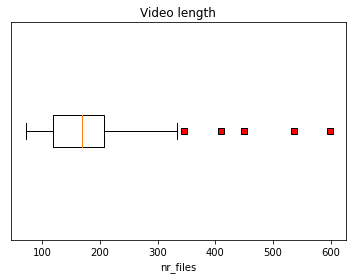

In [3]:
test_dir = os.path.join('data', 'assignment', 'test')

# loop over all class_names and video's and count the number of files per video
meta_data = []
for class_name in os.listdir(test_dir):
    for video_name in os.listdir(os.path.join(test_dir, class_name)):
        meta_data.append({
            'class_name':class_name,
            'video_name':video_name,
            'nr_files':len(os.listdir(os.path.join(test_dir, class_name, video_name))),
        })

# collect them in a dataframe
meta_data_frame = pd.DataFrame(meta_data)

# now show the file distribution
plt.title('Video length')
plt.boxplot(meta_data_frame['nr_files'], vert=False, flierprops=dict(markerfacecolor='r', marker='s'))
plt.xlabel("nr_files")
plt.yticks([])
plt.show()

Now we can collect or define the other parameters for the models.

In [4]:
# take the shortest video as input shape, so all videos can fit
INPUT_SHAPE = min(meta_data_frame['nr_files'])

# load the label_map
LABEL_MAP_PATH = 'data/label_map.txt'
kinetics_classes = [x.strip() for x in open(LABEL_MAP_PATH, 'r')]

# extract the number of classes from the label_map
NUM_CLASSES = len(kinetics_classes)

# now define the frame dimesions 
FRAME_HEIGHT = 224
FRAME_WIDTH = 224

# and the number of channels 
NUM_RGB_CHANNELS = 3
NUM_FLOW_CHANNELS = 2

## Load the models
Now that we have the input parameters ready, we can (down)-load the pre-trained models.
- 1 model for processing the RGB images
- 1 model for processing the optical flow

NOTE: the optical flow model has 1 frame less than the RGB model. This is because the optical flow is calculated between 2 consecutive frames, and thus at the first frame there is no previous frame.

In [5]:
# get the I3D rgb model
rgb_model = Inception_Inflated3d(
    include_top=True,
    weights='rgb_imagenet_and_kinetics',
    input_shape=(INPUT_SHAPE, FRAME_HEIGHT, FRAME_WIDTH, NUM_RGB_CHANNELS),
    classes=NUM_CLASSES
)

# get the I3D flow model
flow_model = Inception_Inflated3d(
    include_top=True,
    weights='flow_imagenet_and_kinetics',
    input_shape=(INPUT_SHAPE - 1, FRAME_HEIGHT, FRAME_WIDTH, NUM_FLOW_CHANNELS),
    classes=NUM_CLASSES
)

/home/willem/Projects/i3d_keras/src/i3d_inception.py:98: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 2 input channels.
  warnings.warn(


## Make predictions

Now that the models are ready, we can predict the acitivity in the videos.

In [6]:
# we collect the outcome in this list for later processing
results = []

# loop over all class_names and video's
for class_name in os.listdir(test_dir):
    for video_name in os.listdir(os.path.join(test_dir, class_name)):

        # get the first x files from the directory 
        files = sorted(os.listdir(os.path.join(test_dir, class_name, video_name)))[:INPUT_SHAPE]
        
        # map the files to file paths
        file_paths = [os.path.join(test_dir, class_name, video_name, file) for file in files]
        
        # collect the rgb files
        npy_rgb_output = f"data/interim/{class_name}_{video_name}_rgb.npy"
        if not os.path.exists(npy_rgb_output):
            rgb = run_rgb(file_paths)
            np.save(npy_rgb_output, rgb)
        rgb_sample = np.load(npy_rgb_output)
        
        # collect the optical flow files
        npy_flow_output = f"data/interim/{class_name}_{video_name}_flow.npy"
        if not os.path.exists(npy_flow_output):
            flow = run_flow(file_paths)
            np.save(npy_flow_output, flow)
        flow_sample = np.load(npy_flow_output)
        
        # make prediction
        rgb_logits = rgb_model.predict(rgb_sample)
        flow_logits = flow_model.predict(flow_sample)
        
        # produce final model logits
        sample_logits = rgb_logits + flow_logits
        
        # produce softmax output from model logit for class probabilities
        sample_logits = sample_logits[0] # we are dealing with just one example
        sample_predictions = np.exp(sample_logits) / np.sum(np.exp(sample_logits))
        
        # sort the indices
        sorted_indices = np.argsort(sample_predictions)[::-1]
        
        # print some data
        print(f"{video_name} = {class_name} => prediction {kinetics_classes[sorted_indices[0]]} ({sample_predictions[sorted_indices[0]] * 100:.2f}%)")
        
        # collect the data
        results.append({
            'video_name':video_name,
            'class_name':class_name,
            'y_pred':kinetics_classes[sorted_indices[0]],
            'confidence':sample_predictions[sorted_indices[0]]
        })

# collect the results in a dataframe
results_df = pd.DataFrame(results)
results_df.to_csv('data/processed/results_experiment_1.csv')
results_df.head()

g24_c01 = Diving => prediction springboard diving (95.36%)
g23_c04 = Diving => prediction springboard diving (99.99%)
g23_c02 = Diving => prediction springboard diving (99.90%)
g22_c04 = Diving => prediction springboard diving (80.49%)
g21_c04 = Diving => prediction springboard diving (63.38%)
g23_c05 = Diving => prediction springboard diving (99.71%)
g22_c06 = Diving => prediction springboard diving (97.90%)
g21_c06 = Diving => prediction springboard diving (92.59%)
g22_c02 = Diving => prediction springboard diving (81.61%)
g24_c06 = Diving => prediction springboard diving (90.56%)
g24_c04 = Diving => prediction dunking basketball (99.91%)
g21_c02 = Diving => prediction springboard diving (99.94%)
g25_c01 = Diving => prediction springboard diving (91.79%)
g22_c01 = Diving => prediction springboard diving (100.00%)
g24_c03 = Diving => prediction springboard diving (81.79%)
g21_c01 = Diving => prediction springboard diving (99.76%)
g21_c07 = Diving => prediction springboard diving (86.9

,video_name,class_name,y_pred,confidence
0,g24_c01,Diving,springboard diving,0.953604
1,g23_c04,Diving,springboard diving,0.999876
2,g23_c02,Diving,springboard diving,0.998995
3,g22_c04,Diving,springboard diving,0.804863
4,g21_c04,Diving,springboard diving,0.633752


## Analyse the results

Before we dive in the qualtiy of the predictions, first let's get an idea how confident the model is about it's predictions.

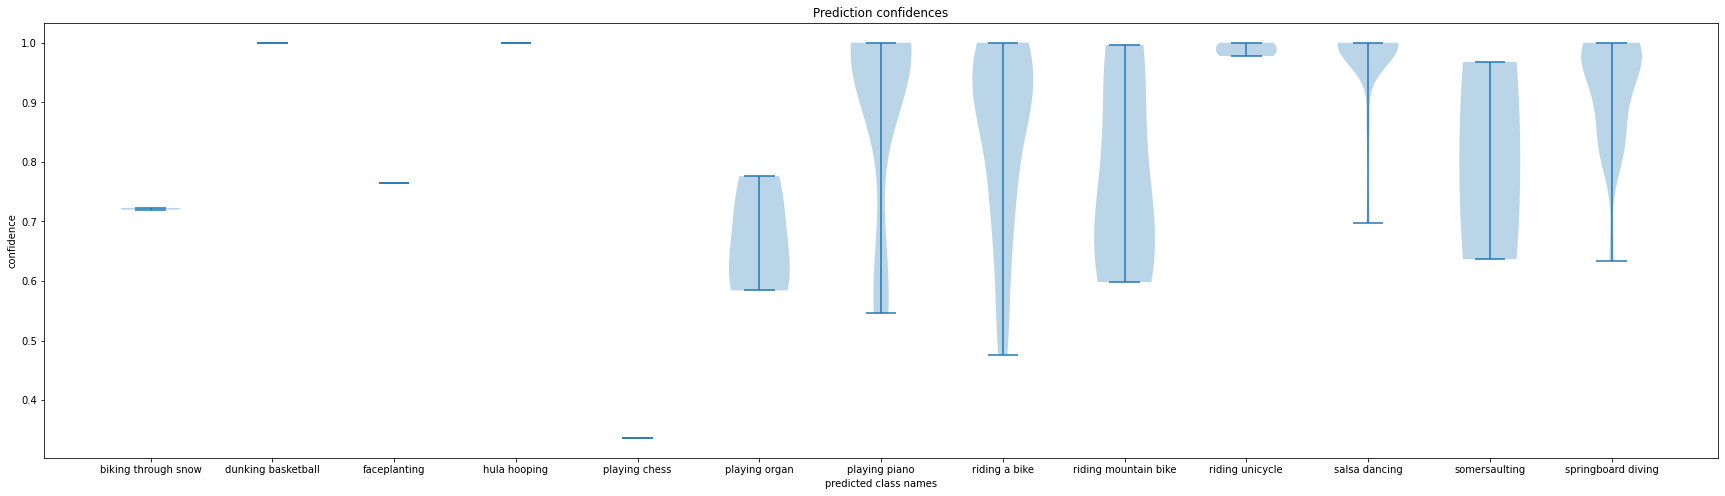

In [7]:
confidences = {}

# collect all confidences per y_pred
for y_pred, group in results_df.groupby('y_pred'):
    confidences[y_pred] = group['confidence']

# now plot the confidence distribution per y_pred
fig, ax = plt.subplots(figsize=(30, 8))
plt.title('Prediction confidences')
plt.xlabel("predicted class names")
plt.ylabel("confidence")
ax.violinplot(confidences.values())
ax.set_xticks(np.arange(1, len(confidences) + 1))
ax.set_xticklabels(confidences.keys())
plt.show()

Ideally we would like to see high confidences, so that we know the model is certain about it's predictions. But there is some spreading towards 50% condifence, so there is something going on.

Now let's calculate how well the model predicts?

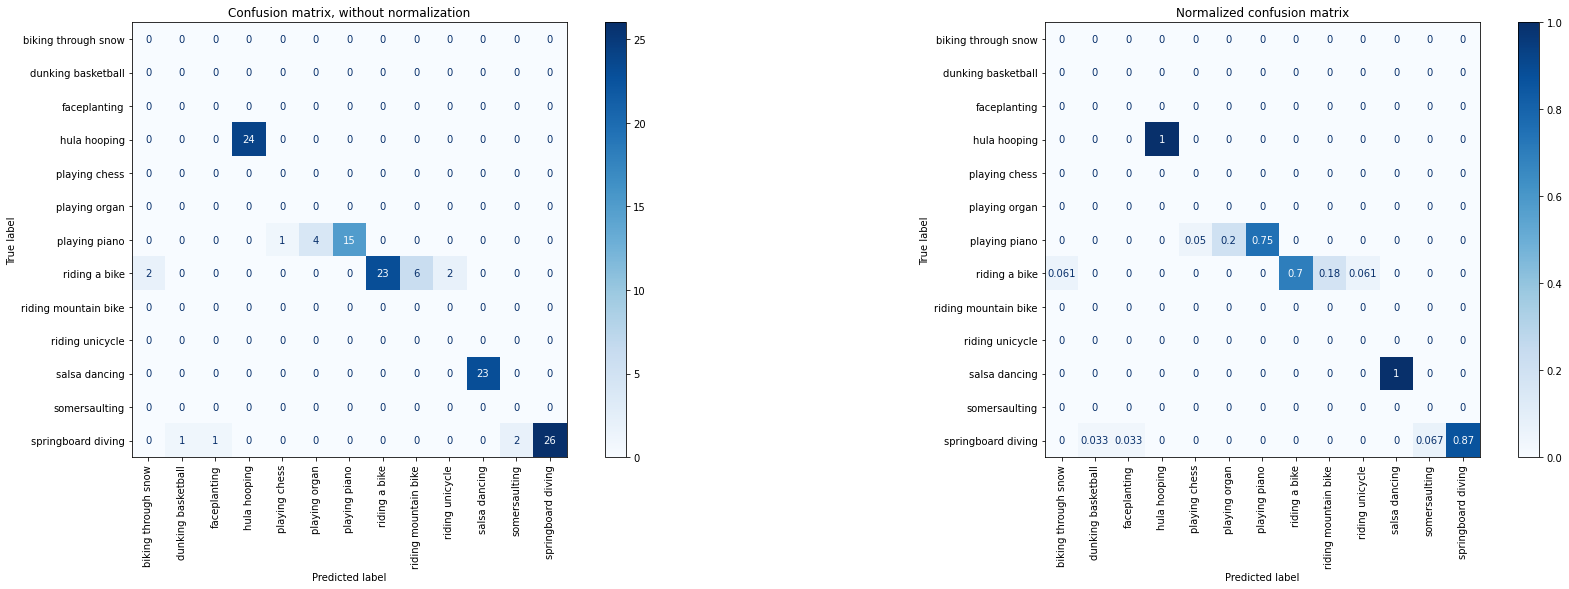

In [10]:
def map_values(row):
    if row['class_name'] == 'Diving':
        return 'springboard diving'
    if row['class_name'] == 'SalsaSpin':
        return 'salsa dancing'
    if row['class_name'] == 'HulaHoop':
        return 'hula hooping'
    if row['class_name'] == 'Biking':
        return 'riding a bike'
    if row['class_name'] == 'PlayingPiano':
        return 'playing piano'
    return np.nan

# map the custom map names to the likely kinetic class names so we can measure the accuracy
results_df['y_true'] = results_df.apply(lambda row : map_values(row), axis=1) 

# Collect the y values
y_true = results_df['y_true']
y_pred = results_df['y_pred']

# fetching the class_names (from y_true and y_pred an map them to the original kinetic class position)
labels = [kinetics_class for kinetics_class in kinetics_classes if kinetics_class in set(y_true).union(set(y_pred))]

# define the figure
fig, axs = plt.subplots(1, 2, figsize=(30, 8))

# plot 2 confusion matrixes
for title, normalize, column in [("Confusion matrix, without normalization", None, 0), ("Normalized confusion matrix", 'true', 1)]:

    # calculate the confusion matrix
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, sample_weight=None, labels=None, normalize=normalize)

    # build the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels).plot(ax=axs[column], cmap=plt.cm.Blues, xticks_rotation='vertical')
    disp.ax_.set_title(title)

Okay, the model made no mistakes at `hula hooping` and `salsa dancing`. At the other videos mistakes were made.

Now let's an overall idication how wel the model did on our test set.

In [11]:
print(sklearn.metrics.classification_report(y_true, y_pred))

                      precision    recall  f1-score   support

 biking through snow       0.00      0.00      0.00         0
  dunking basketball       0.00      0.00      0.00         0
        faceplanting       0.00      0.00      0.00         0
        hula hooping       1.00      1.00      1.00        24
       playing chess       0.00      0.00      0.00         0
       playing organ       0.00      0.00      0.00         0
       playing piano       1.00      0.75      0.86        20
       riding a bike       1.00      0.70      0.82        33
riding mountain bike       0.00      0.00      0.00         0
     riding unicycle       0.00      0.00      0.00         0
       salsa dancing       1.00      1.00      1.00        23
       somersaulting       0.00      0.00      0.00         0
  springboard diving       1.00      0.87      0.93        30

            accuracy                           0.85       130
           macro avg       0.38      0.33      0.35       130
      

/home/willem/.virtualenvs/i3d_keras/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/willem/.virtualenvs/i3d_keras/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/willem/.virtualenvs/i3d_keras/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Discussion
### Video cropping
As mentioned before, i've deliberatlty cropped the first part of the video so that i can predict all videos. i've could have chosen different strategies like:
- chose n discrete bins on video lengths and build models for each bin. If there is a short video than this doesn't have to be a bottleneck for all videos
- crop videos around the center
- crop the video in multiple segments, predict each segment and combine the outcomes of all segments to 1 prediction
- a combination of the above.
I assume that the more video data is analysed, the higher the accuracy would be. I noticed that a diving video was poorly predicted so i've looked into it. The video was quite similar to another, but the activity was started later in the video, and thus it makes sense that the model couldn't recognize the acitivty, because it was cropped before it started.

### Custom class naming
I've also mapped the 5 "custom" classes to the "most likely" kinetic class names. But in the case of `Biking` there are 5 different variants of `riding a bike` in the kinetic dataset, so in some cases (videos) it makes sense that the confidence is low, and possibly incorrect. For example `Biking` video `g25_c04`; it's a small boy riding a bike, recorded from the back. There is only 1 wheel visible throughout the video so it makes sense that this video is classified as `riding unicycle`.

This is my first itteration with the model and the dataset. So now i have a baseline, my next step would be to apply `error analysis` and figure out which next step would be most benificial.

# Training